# **Finetuning Llama model using Code Generation Dataset**

Llama model is mainly fine tuned by using Ludwig framework. It is a low code framework through which we can finetune LLm models.

Here the Llama 7b model is finetuned specifically for "alpaca-code-20k" datatset on a T4 GPU.

To run on a single GPU various strategies were used to navigate memory bottlenecks.

The Strategies are :


1.   Quantisaton
2.   LoRA
3.   QLoRA

By emplying these startegies, we can overcome memory bottlenecks of training 7b model.



In [1]:
#ludwig pakage is installed here...

!pip install ludwig
!pip install ludwig[llm]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.5/987.5 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 12.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 10.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=1ad99a4a34a1f18d29f1ecb0d6a18a261712d083553e8f7cc137622d794f4e60
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

def clear_cache():
  if torch.cuda.is_available():
    model = None
    torch.cuda.empty_cache()

In [3]:
#HuggingFace Token is set to use Llama model...

import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


In [4]:
#Dataset is imported...

from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd

df = pd.read_json("https://raw.githubusercontent.com/sahil280114/codealpaca/master/data/code_alpaca_20k.json")

# We're going to create a new column called `split` where:
# 90% will be assigned a value of 0 -> train set
# 5% will be assigned a value of 1 -> validation set
# 5% will be assigned a value of 2 -> test set
# Calculate the number of rows for each split value
total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to ensure randomness
np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame
df['split'] = split_values
df['split'] = df['split'].astype(int)

# For this webinar, we will just 100 rows of this dataset.
df = df.head(n=100)

In [5]:
df.head(10)

,instruction,input,output,split
0,Create an array of length 5 which contains all...,,"arr = [2, 4, 6, 8, 10]",0
1,Formulate an equation to calculate the height ...,,Height of triangle = opposite side length * si...,0
2,Write a replace method for a string class whic...,"string = ""Hello World!""\nreplace_with = ""Greet...","def replace(self, replace_with):\n new_stri...",0
3,Create an array of length 15 containing number...,,"arr = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33...",0
4,Write a function to find the number of distinc...,"matrix = [[1, 0, 0],\n [1, 0, 1],\n ...",def find_num_distinct_states(matrix):\n sta...,0
5,Create a nested loop to print every combinatio...,,for i in range(10):\n for j in range(10):\n...,0
6,Write a function to find the maximum differenc...,"arr = [5, 3, 17, 11, 9]",def max_difference(arr):\n max_diff = 0\n ...,0
7,Write a function to generate the nth Fibonacci...,< noinput >,def fib(n):\n if n == 0:\n return 0\...,0
8,Write a class to represent a 2D point with x a...,,"class Point:\n def __init__(self, x, y):\n ...",0
9,Write code that removes spaces from a given st...,"string = "" A B C D ""","def remove_spaces(string): \n return """".joi...",0


In [6]:
#Data Preprocessing...

num_self_sufficient = (df['input'] == '').sum()
num_need_contex = df.shape[0] - num_self_sufficient

# We are only using 100 rows of this dataset for this webinar
print(f"Total number of examples in the dataset: {df.shape[0]}")

print(f"% of examples that are self-sufficient: {round(num_self_sufficient/df.shape[0] * 100, 2)}")
print(f"% of examples that are need additional context: {round(num_need_contex/df.shape[0] * 100, 2)}")

Total number of examples in the dataset: 100
% of examples that are self-sufficient: 49.0
% of examples that are need additional context: 51.0


Average number of tokens in the instruction column: 23
Average number of tokens in the input column: 8
Average number of tokens in the output column: 65



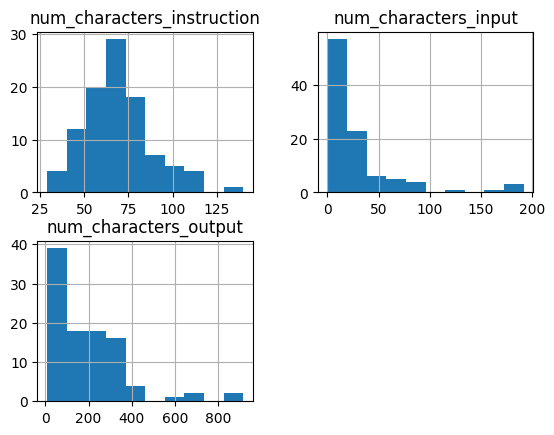

In [7]:
# Calculating the length of each cell in each column
df['num_characters_instruction'] = df['instruction'].apply(lambda x: len(x))
df['num_characters_input'] = df['input'].apply(lambda x: len(x))
df['num_characters_output'] = df['output'].apply(lambda x: len(x))

# Show Distribution
df.hist(column=['num_characters_instruction', 'num_characters_input', 'num_characters_output'])

# Calculating the average
average_chars_instruction = df['num_characters_instruction'].mean()
average_chars_input = df['num_characters_input'].mean()
average_chars_output = df['num_characters_output'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

# **Zero Shot Inference**

In [8]:
zero_shot_config = yaml.safe_load(
  """
  model_type: llm
  base_model: meta-llama/Llama-2-7b-hf

  input_features:
    - name: instruction
      type: text

  output_features:
    - name: output
      type: text

  prompt:
    template: >-
      Below is an instruction that describes a task, paired with an input
      that may provide further context. Write a response that appropriately
      completes the request.

      ### Instruction: {instruction}

      ### Input: {input}

      ### Response:

  generation:
    temperature: 0.1 # Temperature is used to control the randomness of predictions.
    max_new_tokens: 512

  preprocessing:
    split:
      type: fixed

  quantization:
    bits: 4
  """
)

# Just run on 10 examples for now
model = LudwigModel(config=zero_shot_config, logging_level=logging.INFO)
results = model.train(dataset=df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'None': 152 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 154 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 154 for feature 'None'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'output': 275 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 277 (including start and stop symbols)
INFO:ludwig.featur

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.trainers.trainer_llm:
Running evaluation for step: 0, epoch: 0


Evaluation valid:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: <s> below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: create a jsx code that renders a "hello, world!" message in the browser.
### input: 
### response:
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Evaluation valid:  25%|██▌       | 1/4 [00:49<02:29, 49.82s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: <s> below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: generate a random number between 0 and 1 (inclusively).
### input: 
### response:


Evaluation valid:  50%|█████     | 2/4 [01:34<01:33, 46.92s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: <s> below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: create a quick-sort algorithm in python.
### input: 
### response:


Evaluation valid:  75%|███████▌  | 3/4 [02:21<00:47, 47.01s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: <s> below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: write a function that takes in a list of numbers and prints out the greatest number.
### input: list = [8, 2, 14, 25]
### response:


Evaluation test :   0%|          | 0/8 [00:00<?, ?it/s]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: <s> below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: create a c++ program for randomly shuffling an array of integers.
### input: 
### response:
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Evaluation test :  12%|█▎        | 1/8 [00:44<05:08, 44.09s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: <s> below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: remove the boilerplate code from the program for printing 10 random numbers.
### input: import random

# generate 10 random numbers
for i in range(10):
    # todo
### response:


Evaluation test :  25%|██▌       | 2/8 [01:28<04:25, 44.25s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: <s> below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: write an sql query to calculate the average order price for each product category in the "orders" table.
### input: 
### response:


Evaluation test :  38%|███▊      | 3/8 [02:13<03:42, 44.58s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: <s> below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: change the variable `x` to the data type desired.
### input: x = 'hello world!'
### response:


Evaluation test :  50%|█████     | 4/8 [03:00<03:01, 45.45s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: <s> below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: is it possible to set a breakpoint that is not associated with any source code line in a gdb program?
### input: 
### response:


Evaluation test :  62%|██████▎   | 5/8 [03:45<02:15, 45.28s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: <s> below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: create a table to store customer information.
### input: 
### response:


Evaluation test :  75%|███████▌  | 6/8 [04:30<01:30, 45.20s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: <s> below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: parse the string and return the number of unique alphabets in the string.
### input: stringinput = "apple"
### response:


Evaluation test :  88%|████████▊ | 7/8 [05:15<00:45, 45.15s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: <s> below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: write a function to remove all whitespace characters from a given string.
### input: mystring = "hello   world    "
### response:


Evaluation test : 100%|██████████| 8/8 [06:00<00:00, 45.07s/it]

INFO:ludwig.trainers.trainer_llm:Evaluation took 9m 6.7536s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤═══════════════════╤════════════════════╤═════════════════════════╤════════════════╤═════════════════════╤══════════════════╕
│ output     │ char_error_rate   │ loss               │ next_token_perplexity   │ perplexity     │ sequence_accuracy   │ token_accuracy   │
╞════════════╪═══════════════════╪════════════════════╪═════════════════════════╪════════════════╪═════════════════════╪══════════════════╡
│ train      │                   │                    │                         │                │                     │                  │
├────────────┼───────────────────┼────────────────────┼─────────────────────────┼────────────────┼─────────────────────┼──────────────────┤
│ validation │ 0.99365234375     │ 10.373493194580078 │ 32000.064453125         │ 32000.00390625 │ 0.0                 │ 0.0              │
├────────────┼───────────────────┼────────────────────┼────

# **Fine Tuning**

In [9]:
model = None
clear_cache()

qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: meta-llama/Llama-2-7b-hf

input_features:
  - name: instruction
    type: text

output_features:
  - name: output
    type: text

prompt:
  template: >-
    Below is an instruction that describes a task, paired with an input
    that provides further context. Write a response that appropriately
    completes the request.

    ### Instruction: {instruction}

    ### Input: {input}

    ### Response:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

trainer:
  type: finetune
  epochs: 5
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.00001
  optimizer:
    type: adam
    params:
      eps: 1.e-8
      betas:
        - 0.9
        - 0.999
      weight_decay: 0
  learning_rate_scheduler:
    warmup_fraction: 0.03
    reduce_on_plateau: 0
"""
)

model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run_0                                                   │
├──────────────────┼─────────────────────────────────────────────────────────────────

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.util

trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 350 step(s), approximately 5 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 350 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training:  20%|█▉        | 69/350 [00:46<03:21,  1.39it/s]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  20%|██        | 70/350 [00:47<03:47,  1.23it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 70, epoch: 1


Evaluation test : 100%|██████████| 10/10 [00:19<00:00,  1.96s/it]

INFO:ludwig.trainers.trainer:Evaluation took 28.5303s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤═══════════════════╤════════╤═════════════════════════╤══════════════╤═════════════════════╤══════════════════╕
│ output     │   char_error_rate │   loss │   next_token_perplexity │   perplexity │   sequence_accuracy │   token_accuracy │
╞════════════╪═══════════════════╪════════╪═════════════════════════╪══════════════╪═════════════════════╪══════════════════╡
│ train      │            0.5948 │ 1.0707 │              14319.7373 │   31927.8184 │              0.0000 │           0.0000 │
├────────────┼───────────────────┼────────┼─────────────────────────┼──────────────┼─────────────────────┼──────────────────┤
│ validation │            0.7243 │ 1.8826 │              17133.6836 │   31834.2051 │              0.0000 │           0.0015 │
├────────────┼───────────────────┼────────┼─────────────────────────┼──────────────┼─────────────────────┼──────────────────┤
│ test       │         


Training:  39%|███▉      | 138/350 [02:01<02:07,  1.67it/s]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  40%|████      | 140/350 [02:04<04:43,  1.35s/it]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 140, epoch: 2


Evaluation test : 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]

INFO:ludwig.trainers.trainer:Evaluation took 29.4363s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤═══════════════════╤════════╤═════════════════════════╤══════════════╤═════════════════════╤══════════════════╕
│ output     │   char_error_rate │   loss │   next_token_perplexity │   perplexity │   sequence_accuracy │   token_accuracy │
╞════════════╪═══════════════════╪════════╪═════════════════════════╪══════════════╪═════════════════════╪══════════════════╡
│ train      │            0.4113 │ 1.1295 │              16315.2393 │   31376.0391 │              0.0000 │           0.0152 │
├────────────┼───────────────────┼────────┼─────────────────────────┼──────────────┼─────────────────────┼──────────────────┤
│ validation │            0.7231 │ 1.8010 │              17018.3477 │   31825.4629 │              0.0000 │           0.0015 │
├────────────┼───────────────────┼────────┼─────────────────────────┼──────────────┼─────────────────────┼──────────────────┤
│ test       │         


Training:  59%|█████▉    | 207/350 [03:19<01:32,  1.54it/s]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  60%|██████    | 210/350 [03:22<01:46,  1.32it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 210, epoch: 3


Evaluation test : 100%|██████████| 10/10 [00:20<00:00,  2.10s/it]

INFO:ludwig.trainers.trainer:Evaluation took 29.8798s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤═══════════════════╤════════╤═════════════════════════╤══════════════╤═════════════════════╤══════════════════╕
│ output     │   char_error_rate │   loss │   next_token_perplexity │   perplexity │   sequence_accuracy │   token_accuracy │
╞════════════╪═══════════════════╪════════╪═════════════════════════╪══════════════╪═════════════════════╪══════════════════╡
│ train      │            0.6750 │ 1.4871 │              18901.7129 │   31932.5098 │              0.0000 │           0.0000 │
├────────────┼───────────────────┼────────┼─────────────────────────┼──────────────┼─────────────────────┼──────────────────┤
│ validation │            0.7183 │ 1.5701 │              16783.6270 │   31803.6465 │              0.0000 │           0.0022 │
├────────────┼───────────────────┼────────┼─────────────────────────┼──────────────┼─────────────────────┼──────────────────┤
│ test       │         


Training:  79%|███████▉  | 276/350 [04:32<00:48,  1.53it/s]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  80%|████████  | 280/350 [04:36<01:02,  1.12it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 280, epoch: 4


Evaluation test : 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]

INFO:ludwig.trainers.trainer:Evaluation took 28.6671s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤═══════════════════╤════════╤═════════════════════════╤══════════════╤═════════════════════╤══════════════════╕
│ output     │   char_error_rate │   loss │   next_token_perplexity │   perplexity │   sequence_accuracy │   token_accuracy │
╞════════════╪═══════════════════╪════════╪═════════════════════════╪══════════════╪═════════════════════╪══════════════════╡
│ train      │            0.5632 │ 0.3765 │              13648.1777 │   31571.8926 │              0.0000 │           0.0058 │
├────────────┼───────────────────┼────────┼─────────────────────────┼──────────────┼─────────────────────┼──────────────────┤
│ validation │            0.7135 │ 1.3502 │              16228.5762 │   31778.4512 │              0.0000 │           0.0026 │
├────────────┼───────────────────┼────────┼─────────────────────────┼──────────────┼─────────────────────┼──────────────────┤
│ test       │         


Training:  99%|█████████▊| 345/350 [05:48<00:03,  1.65it/s]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training: 100%|██████████| 350/350 [05:53<00:00,  1.31s/it]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 350, epoch: 5


Evaluation test : 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]

INFO:ludwig.trainers.trainer:Evaluation took 29.6896s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤═══════════════════╤════════╤═════════════════════════╤══════════════╤═════════════════════╤══════════════════╕
│ output     │   char_error_rate │   loss │   next_token_perplexity │   perplexity │   sequence_accuracy │   token_accuracy │
╞════════════╪═══════════════════╪════════╪═════════════════════════╪══════════════╪═════════════════════╪══════════════════╡
│ train      │            0.3538 │ 0.8524 │              15048.6895 │   31028.8086 │              0.0000 │           0.0247 │
├────────────┼───────────────────┼────────┼─────────────────────────┼──────────────┼─────────────────────┼──────────────────┤
│ validation │            0.7087 │ 1.2056 │              15852.2207 │   31766.7871 │              0.0000 │           0.0019 │
├────────────┼───────────────────┼────────┼─────────────────────────┼──────────────┼─────────────────────┼──────────────────┤
│ test       │         


Training: 100%|██████████| 350/350 [06:24<00:00,  1.10s/it]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════╤════════════════════╕
│ Validation feature           │ output             │
├──────────────────────────────┼────────────────────┤
│ Validation metric            │ loss               │
├──────────────────────────────┼────────────────────┤
│ Best model step              │ 350                │
├──────────────────────────────┼────────────────────┤
│ Best model epoch             │ 6                  │
├──────────────────────────────┼────────────────────┤
│ Best model's validation loss │ 1.2055552005767822 │
├──────────────────────────────┼────────────────────┤
│ Best model's test loss       │ 1.2787729501724243 │
╘══════════════════════════════╧════════════════════╛
INFO:ludwig.api:
Finished: api_experiment_run
INFO:ludwig.api:Saved to

In [12]:
test_examples = pd.DataFrame([
      {
            "instruction": "Create an array of length 5 which contains all even numbers between 1 and 10.",
            "input": ''
      },
      {
            "instruction": "Create an array of length 15 containing numbers divisible by 3 up to 45.",
            "input": "",
      },
      {
            "instruction": "Create a nested loop to print every combination of numbers between 0-9",
            "input": ""
      },
      {
            "instruction": "Generate a function that computes the sum of the numbers in a given list",
            "input": "",
      },
      {
            "instruction": "Generate a function to add two numbers in a given list.",
            "input": "",
      },
      {
            "instruction": "Print out the values in the following dictionary.",
            "input": "my_dict = {\n  'name': 'John Doe',\n  'age': 32,\n  'city': 'New York'\n}",
      },
])

predictions = model.predict(test_examples)[0]
for input_with_prediction in zip(test_examples['instruction'], test_examples['input'], predictions['output_response']):
  print(f"Instruction: {input_with_prediction[0]}")
  print(f"Input: {input_with_prediction[1]}")
  print(f"Generated Output: {input_with_prediction[2][0]}")
  print("\n\n")

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: <s> below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriately completes the request.
### instruction: create an array of length 5 which contains all even numbers between 1 and 10.
### input: 
### response:
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: <s> below is an instruction that describes a task, paired with an input that provide

Prediction: 100%|██████████| 1/1 [00:28<00:00, 28.06s/it]


INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer


Instruction: Create an array of length 5 which contains all even numbers between 1 and 10.
Input: 
Generated Output: sierp = [2, 4, 6, 8, 10]



Instruction: Create an array of length 15 containing numbers divisible by 3 up to 45.
Input: 
Generated Output: sierp = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45]



Instruction: Create a nested loop to print every combination of numbers between 0-9
Input: 
Generated Output: sierpana = [0,1,2,3,4,5,6,7,8,9]
for i in range(10):
    for j in range(10):
        print(augustana[i], augustana[j])



Instruction: Generate a function that computes the sum of the numbers in a given list
Input: 
Generated Output: sierp = [1, 2, 3, 4, 5]
sum = 0
for i in sierp:
    sum += i
return sum



Instruction: Generate a function to add two numbers in a given list.
Input: 
Generated Output: sierp = [1, 2, 3]
def add_two_numbers(augs):
    return sum(augs)



Instruction: Print out the values in the following dictionary.
Input: my_dict = {
  'name':

/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))
